In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'uncer.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
alpha = 10
beta =  0.11
from scipy.stats import invgamma as inv
np.sqrt(inv.rvs(a = alpha ,scale = beta , size = 1 )[0])

0.09571825427611842

In [6]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

In [12]:
predictions_dict['m1']['metric']

{'DIC': array([], dtype=float64),
 'GR-ratio': {'lockdown_R0': 1.0054894303886277,
  'T_inc': 1.00296411203498,
  'T_inf': 1.0289018866205022,
  'T_recov': 1.0798835320428204,
  'T_recov_fatal': 1.0190597353543864,
  'P_fatal': 1.0258711637705729,
  'E_hosp_ratio': 1.0052880960587611,
  'I_hosp_ratio': 1.028807487551861,
  'gamma': 1.115205992744407}}

In [ ]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 
# m2_params = copy.deepcopy(config['fitting'])
# m2_params['split']['val_period'] = 0
# predictions_dict['m2'] = single_fitting_cycle(**m2_params)

# predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_08122020_tracker.pkl
splitting data ..
splitting data ..


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 12/15000 [00:00<02:10, 114.93it/s]

train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 142                 | 143                 | 144                 | 145                 | 146                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-15 00:00:00 | 2020-09-16 00:00:00 | 2020-09-17 00:00:00 | 2020-09-18 00:00:00 | 2020-09-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 174004.29           | 176082.43           | 178385.0            | 180668.0            | 182203.0            |
| active      | 31867.43            | 32078.57            | 33326.0             | 34629.0             | 31009.0

 72%|███████▏  | 10764/15000 [01:38<00:35, 119.17it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
 82%|████████▏ | 12323/15000 [01:52<00:23, 112.70it/s]

In [9]:
predictions_dict['m1']['best_params']

OrderedDict([('lockdown_R0', 0.982038532286418),
             ('T_inc', 4.972605439663173),
             ('T_inf', 4.9813024117964),
             ('T_recov', 22.51907490209268),
             ('T_recov_fatal', 33.53700725103488),
             ('P_fatal', 0.04433582049943822),
             ('E_hosp_ratio', 0.8260792758899549),
             ('I_hosp_ratio', 0.15998223020575905),
             ('gamma', 0.01707192020506797)])

In [10]:
predictions_dict['m2']['best_params']

KeyError: 'm2'

## Loss Dataframes

### M1 Loss DataFrame

In [11]:
predictions_dict['m1']['df_loss']

,train,val
total,0.31091,1.05922
active,2.64097,24.0666
recovered,0.426441,5.70238
deceased,0.263244,0.229338


### M2 Loss DataFrame

In [11]:
predictions_dict['m2']['df_loss']

,train
total,0.156731
active,2.78207
recovered,0.279443
deceased,0.454417


## Sensitivity Plot

100%|██████████| 101/101 [00:00<00:00, 111.09it/s]


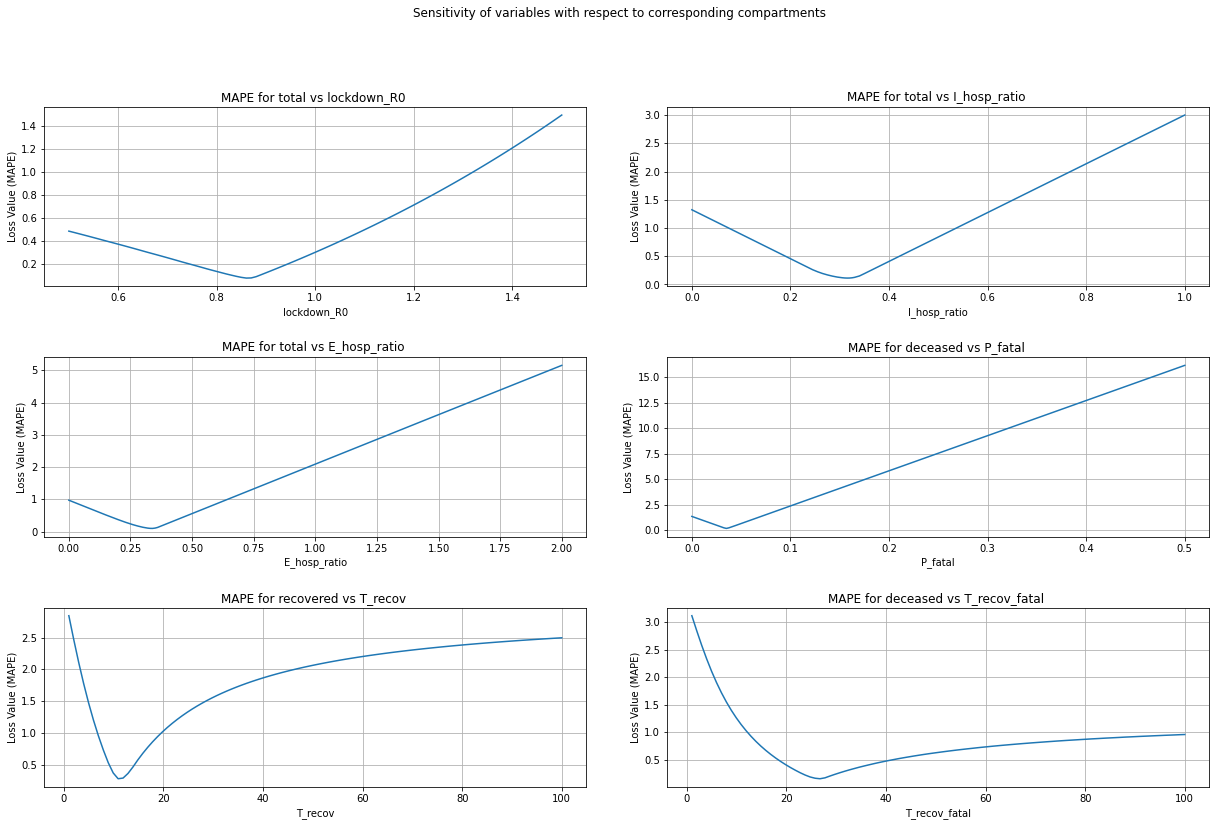

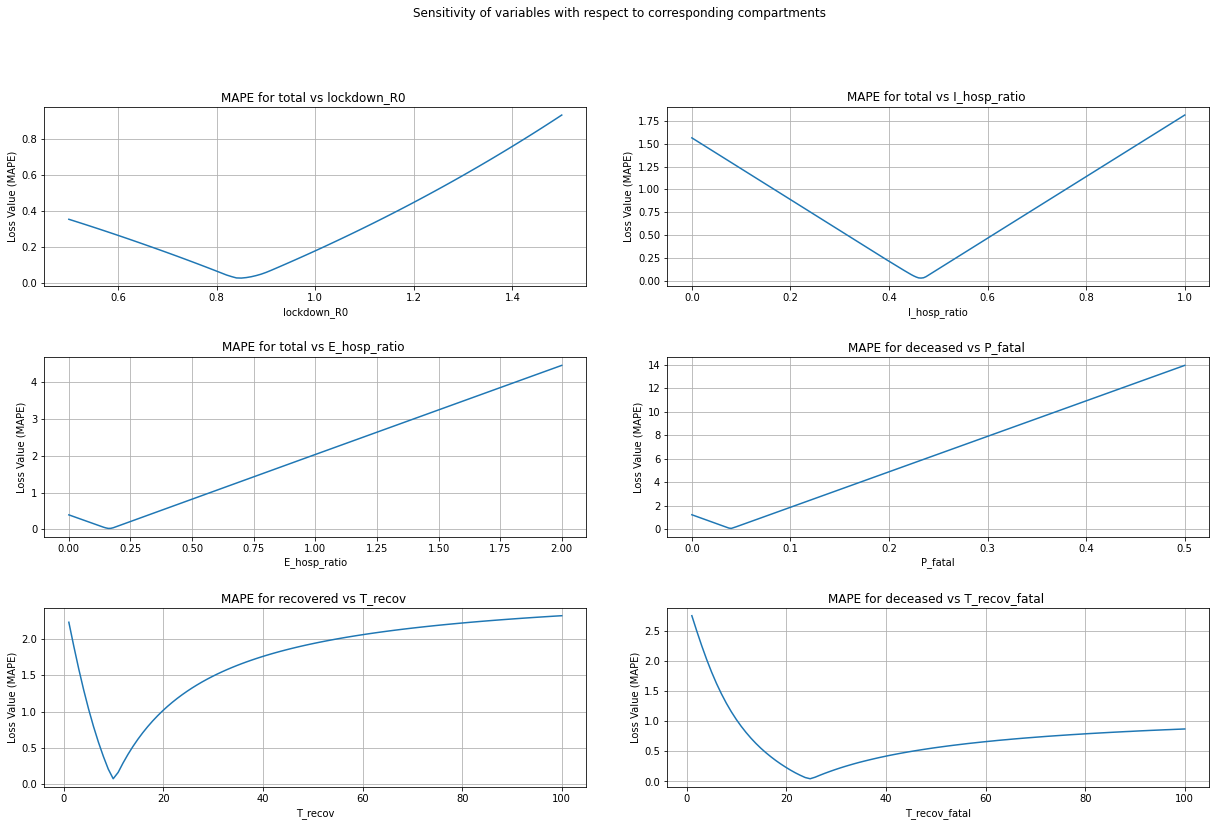

In [12]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

0it [00:00, ?it/s]

getting forecasts ..
getting forecasts ..


1500it [00:10, 137.08it/s]
14it [00:00, 136.88it/s]

getting forecasts ..


1500it [00:10, 144.06it/s]


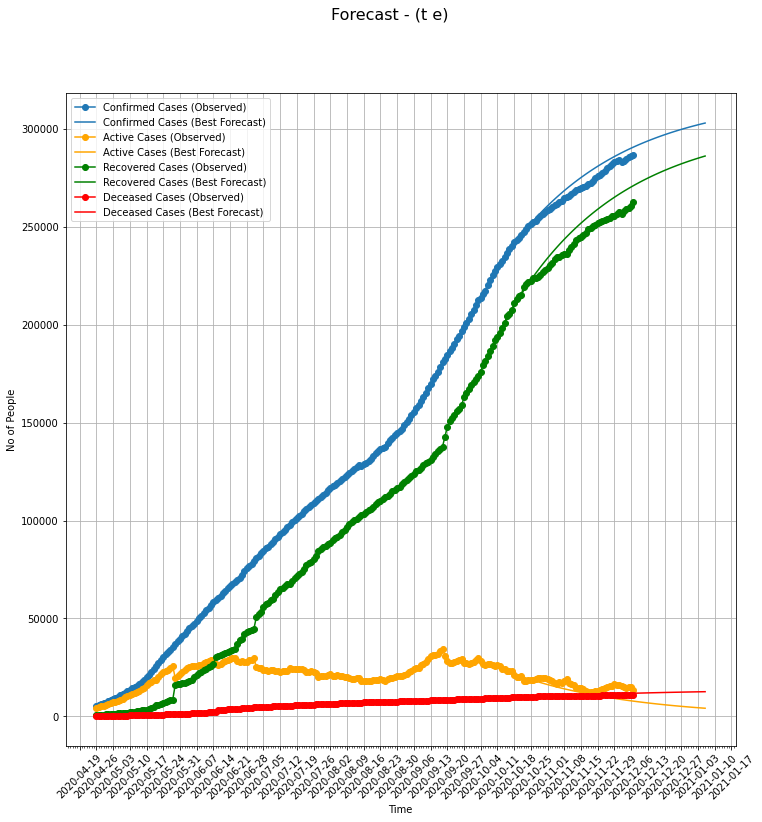

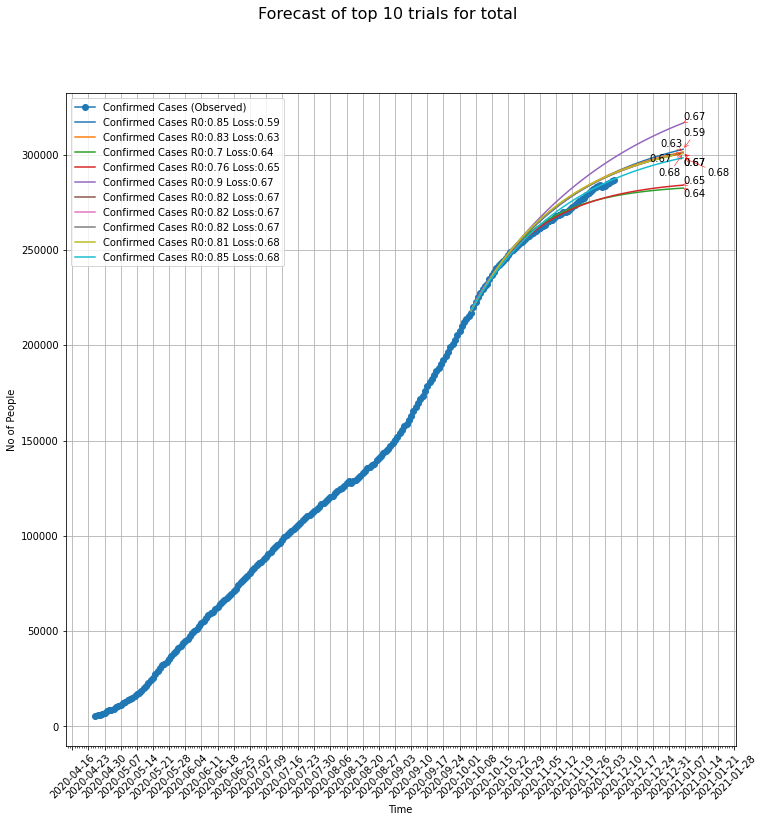

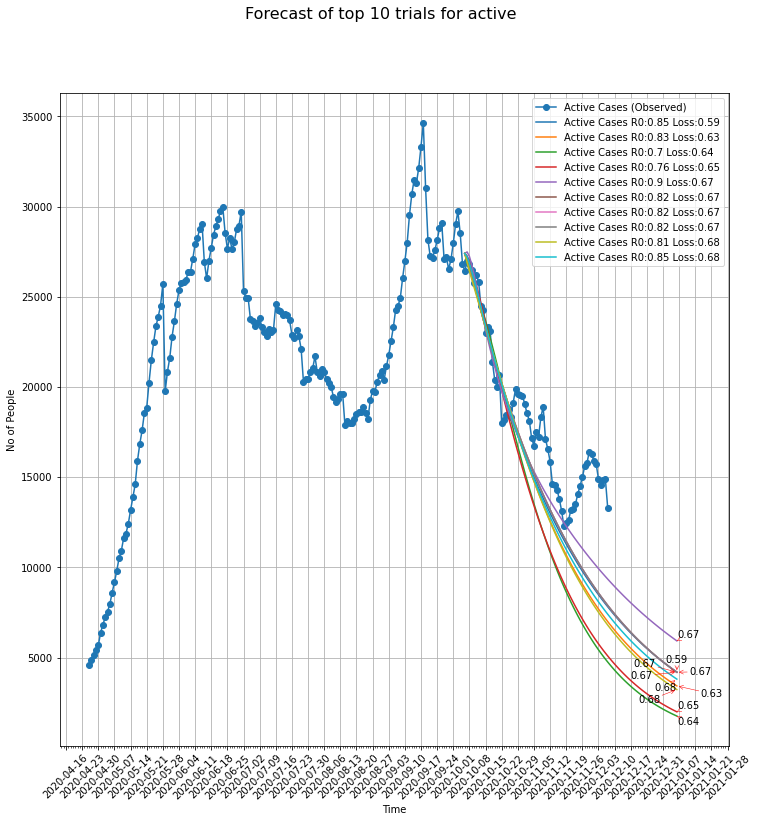

In [13]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [14]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

15it [00:00, 147.00it/s]

getting forecasts ..


1500it [00:09, 157.66it/s]


In [15]:
uncertainty.ensemble_mean_forecast['df_loss']

{'active': 4.24228967046674,
 'recovered': 0.34126375227154376,
 'deceased': 0.6461870326167799,
 'total': 0.22351238028037637}

In [18]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [19]:
uncertainty_forecasts[2.5]['df_loss_perc']

,train
total,0.0975126


In [20]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

AttributeError: 'MCUncertainty' object has no attribute 'beta_loss'

ValueError: Could not interpret input 'date'

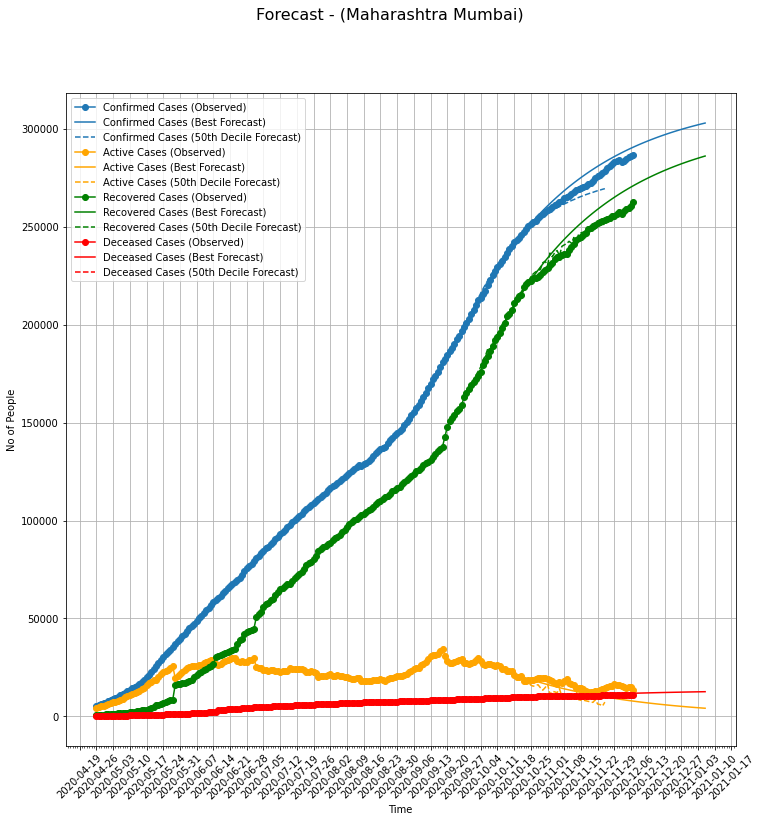

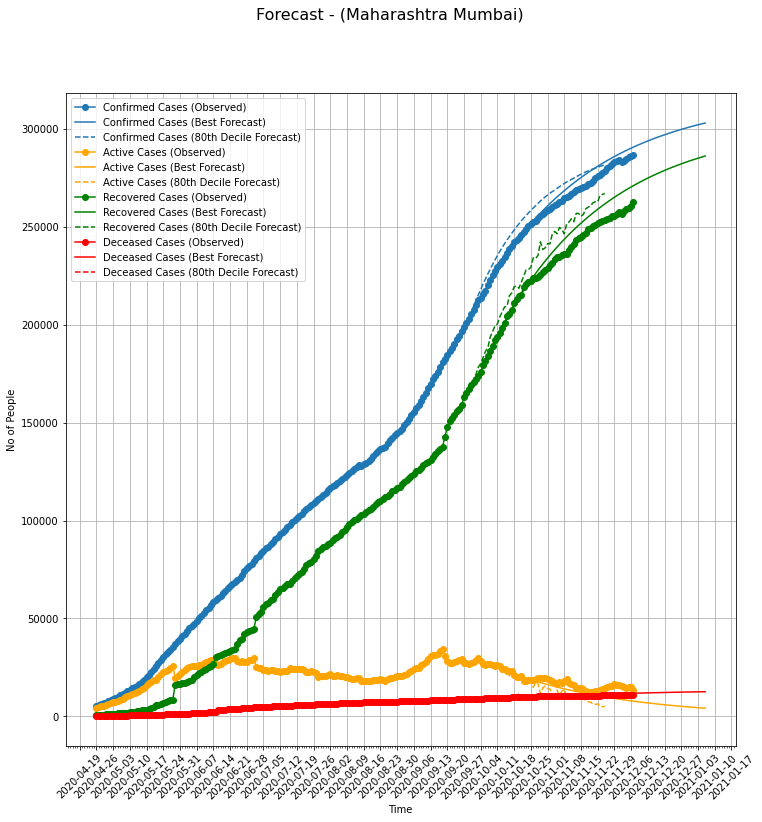

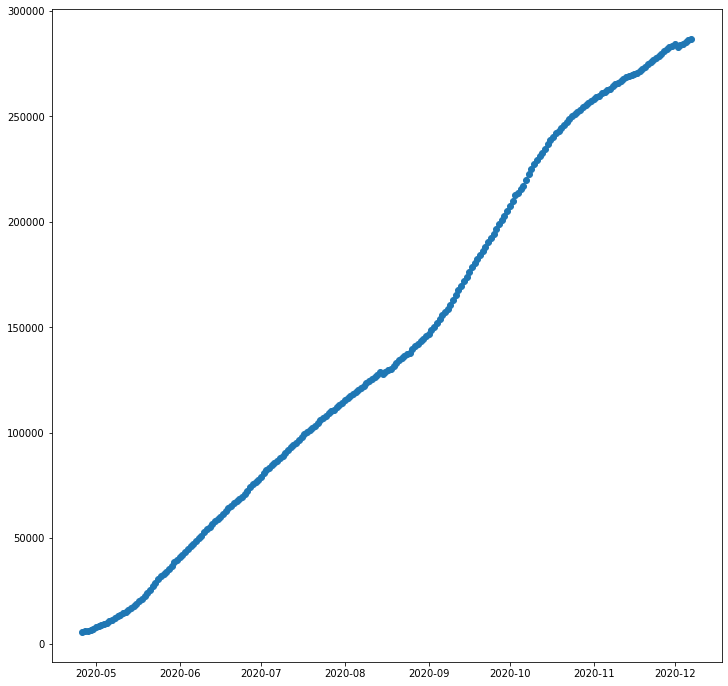

In [28]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [20]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

In [1]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [2]:
a.update(b)

In [3]:
a


{1: [4, 5], 2: [5, 6], 3: [7, 8]}